In [1]:
# 0. Setup
import os
import importlib
import numpy as np
import pandas as pd

import tdabball as tdb
importlib.reload(tdb)

print("Working directory:", os.getcwd())
os.listdir()

Working directory: /home/jovyan/work/tdaMCBBproject


['README.md',
 '.git',
 'tdabball.py',
 'TDAbasketballNotebook.ipynb',
 'MCBBdata.Rproj',
 'downloadshotdata.qmd',
 '.DS_Store',
 '.ipynb_checkpoints',
 'data',
 '__pycache__']

In [2]:
shots = tdb.load_shot_data("data")   # loads all NBA + MBB parquet files
nba = shots.nba_by_season            # dict: {'2012': df, '2013': df, ...}
mbb = shots.mbb_by_season

In [3]:
# Define eras
era1_years = ["2012", "2013", "2014"]
era2_years = ["2015", "2016", "2017", "2018"]
era3_years = ["2019", "2020", "2021", "2022", "2023", "2024"]

In [4]:
X_era1 = tdb.era_cloud(nba, era1_years)
X_era2 = tdb.era_cloud(nba, era2_years)
X_era3 = tdb.era_cloud(nba, era3_years)

X_era1.shape, X_era2.shape, X_era3.shape

((775703, 2), (1125107, 2), (1684604, 2))

In [5]:
def subsample(X, n=15000, seed=0):
    rng = np.random.default_rng(seed)
    if len(X) <= n:
        return X
    idx = rng.choice(len(X), size=n, replace=False)
    return X[idx]

In [6]:
X1 = subsample(X_era1, n=5000, seed=1)
X2 = subsample(X_era2, n=5000, seed=2)
X3 = subsample(X_era3, n=5000, seed=3)

X1.shape, X2.shape, X3.shape   # all should be (15000, 2)

((5000, 2), (5000, 2), (5000, 2))

In [7]:
dgms_era1 = tdb.persistence_gtda(X1, maxdim=1)

In [8]:
dgms_era2 = tdb.persistence_gtda(X2, maxdim=1)

In [10]:
dgms_era3 = tdb.persistence_gtda(X3, maxdim=1)

In [11]:
[d.shape for d in dgms_era1], [d.shape for d in dgms_era2], [d.shape for d in dgms_era3]

([(3, 1), (3, 1)], [(3, 1), (3, 1)], [(3, 1), (3, 1)])

In [12]:
import numpy as np

def subsample(X, n=5000, seed=0):
    rng = np.random.default_rng(seed)
    if len(X) <= n:
        return X
    idx = rng.choice(len(X), size=n, replace=False)
    return X[idx]

# Rebuild subsampled clouds
X1 = subsample(X_era1, n=5000, seed=1)
X2 = subsample(X_era2, n=5000, seed=2)
X3 = subsample(X_era3, n=5000, seed=3)

X1.shape, X2.shape, X3.shape

((5000, 2), (5000, 2), (5000, 2))

In [13]:
dgms_era1_ripser = tdb.persistence_ripser(X1, maxdim=1)

In [14]:
dgms_era2_ripser = tdb.persistence_ripser(X2, maxdim=1)

In [15]:
dgms_era3_ripser = tdb.persistence_ripser(X3, maxdim=1)

In [16]:
[d.shape for d in dgms_era1_ripser], [d.shape for d in dgms_era2_ripser], [d.shape for d in dgms_era3_ripser]

([(1496, 2), (705, 2)], [(1492, 2), (732, 2)], [(1357, 2), (676, 2)])

In [17]:
d12 = tdb.diagram_distance(dgms_era1_ripser[1], dgms_era2_ripser[1], metric="bottleneck")
d23 = tdb.diagram_distance(dgms_era2_ripser[1], dgms_era3_ripser[1], metric="bottleneck")
d13 = tdb.diagram_distance(dgms_era1_ripser[1], dgms_era3_ripser[1], metric="bottleneck")

d12, d23, d13

(1.4947013854980469, 1.5155448913574219, 1.701796531677246)

In [18]:
w12 = tdb.diagram_distance(dgms_era1_ripser[1], dgms_era2_ripser[1], metric="wasserstein")
w23 = tdb.diagram_distance(dgms_era2_ripser[1], dgms_era3_ripser[1], metric="wasserstein")
w13 = tdb.diagram_distance(dgms_era1_ripser[1], dgms_era3_ripser[1], metric="wasserstein")

w12, w23, w13

(40.82437782106665, 67.07536878831479, 94.81404830508376)

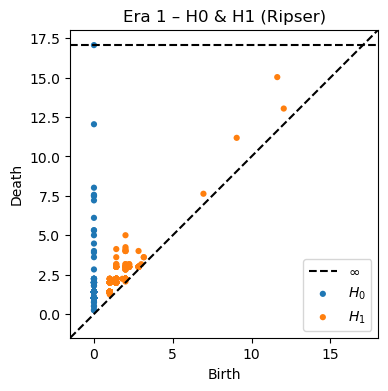

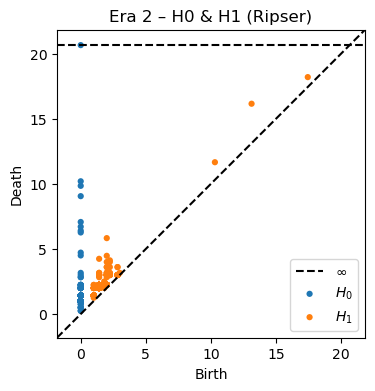

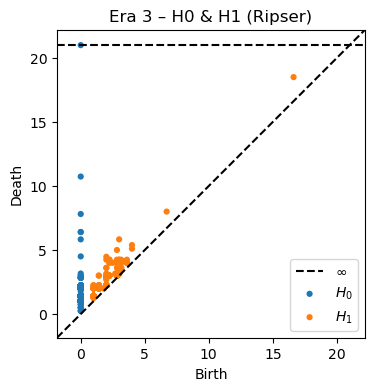

In [20]:
from persim import plot_diagrams
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plot_diagrams(dgms_era1_ripser, title="Era 1 – H0 & H1 (Ripser)")
plt.show()

plt.figure(figsize=(10,4))
plot_diagrams(dgms_era2_ripser, title="Era 2 – H0 & H1 (Ripser)")
plt.show()

plt.figure(figsize=(10,4))
plot_diagrams(dgms_era3_ripser, title="Era 3 – H0 & H1 (Ripser)")
plt.show()

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
coords = pca.fit_transform(tda_features)

coords

array([[-2.67469811e+01, -2.73435439e-02],
       [-4.96105472e-01,  5.32199994e-02],
       [ 2.72430866e+01, -2.58764555e-02]])

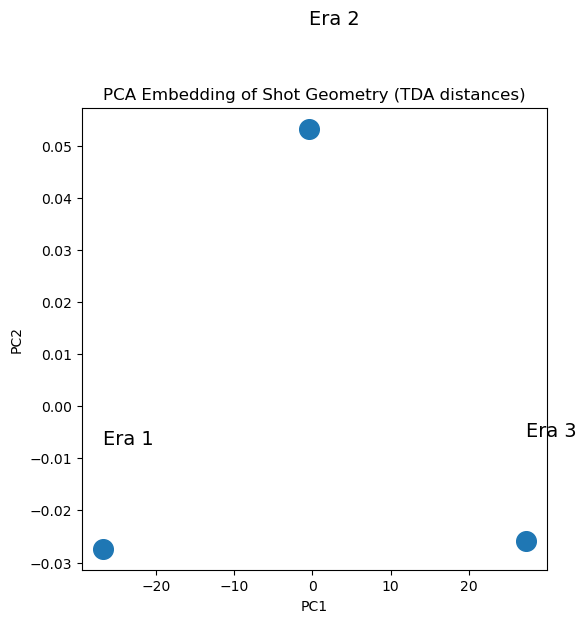

In [27]:
plt.figure(figsize=(6,6))
plt.scatter(coords[:,0], coords[:,1], s=200)

labels = ["Era 1", "Era 2", "Era 3"]
for i, label in enumerate(labels):
    plt.text(coords[i,0] + 0.02, coords[i,1] + 0.02, label, fontsize=14)

plt.title("PCA Embedding of Shot Geometry (TDA distances)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [28]:
import numpy as np
import pandas as pd

# -----------------------------
# 1. Pull full dataset (NBA only)
# -----------------------------
nba_all = shots.nba_all.copy()

# -----------------------------
# 2. Ensure we have shot_clock
# -----------------------------
if "shot_clock" not in nba_all.columns:
    # compute shot clock if missing
    # hoopR often gives "shot_clock" but if missing:
    # use the official rule: shot clock = time remaining in possession
    # but without possession-level data, best fallback is game_clock
    nba_all["shot_clock"] = nba_all["clock_seconds"]

# Explicitly cap at 24
nba_all["shot_clock"] = nba_all["shot_clock"].clip(0,24)

# -----------------------------
# 3. Build clock buckets
# -----------------------------
def assign_bucket(sc):
    if sc >= 17:
        return "Transition (17–24s)"
    elif sc >= 7:
        return "Set Offense (7–17s)"
    else:
        return "Desperation (0–7s)"

nba_all["clock_bucket"] = nba_all["shot_clock"].apply(assign_bucket)

nba_all["clock_bucket"].value_counts()


clock_bucket
Transition (17–24s)    2502508
Set Offense (7–17s)     601580
Desperation (0–7s)      481326
Name: count, dtype: int64

In [29]:
# Extract coordinates for each bucket
X_transition = nba_all[nba_all.clock_bucket=="Transition (17–24s)"][["coordinate_x","coordinate_y"]].to_numpy()
X_setoff = nba_all[nba_all.clock_bucket=="Set Offense (7–17s)"][["coordinate_x","coordinate_y"]].to_numpy()
X_desper = nba_all[nba_all.clock_bucket=="Desperation (0–7s)"][["coordinate_x","coordinate_y"]].to_numpy()

X_transition.shape, X_setoff.shape, X_desper.shape

((2502508, 2), (601580, 2), (481326, 2))

In [32]:
import numpy as np

def subsample(X, n_samples=10000, seed=0):
    np.random.seed(seed)
    if X.shape[0] > n_samples:
        idx = np.random.choice(X.shape[0], size=n_samples, replace=False)
        return X[idx]
    else:
        return X

# -------------------------
# Apply subsampling
# -------------------------
X_trans_sub = subsample(X_transition, n_samples=8000)
X_set_sub   = subsample(X_setoff,     n_samples=8000)
X_desp_sub  = subsample(X_desper,     n_samples=8000)

X_trans_sub.shape, X_set_sub.shape, X_desp_sub.shape

((8000, 2), (8000, 2), (8000, 2))

In [33]:
dgms_trans = tdb.persistence_ripser(X_trans_sub, maxdim=1)

In [34]:
dgms_set   = tdb.persistence_ripser(X_set_sub,   maxdim=1)

In [35]:
dgms_desp  = tdb.persistence_ripser(X_desp_sub,  maxdim=1)

In [37]:
[d.shape for d in dgms_trans]

[(1805, 2), (1036, 2)]

In [38]:
[d.shape for d in dgms_set]

[(1793, 2), (1021, 2)]

In [39]:
[d.shape for d in dgms_desp]

[(1995, 2), (1107, 2)]

In [40]:
# H1 distances (compare looping structure)
d_trans_set = tdb.diagram_distance(dgms_trans[1], dgms_set[1], metric="bottleneck")
d_set_desp  = tdb.diagram_distance(dgms_set[1],  dgms_desp[1], metric="bottleneck")
d_trans_desp= tdb.diagram_distance(dgms_trans[1], dgms_desp[1], metric="bottleneck")

d_trans_set, d_set_desp, d_trans_desp

(1.0, 2.4913744926452637, 2.4913744926452637)

In [41]:
w_trans_set = tdb.diagram_distance(dgms_trans[1], dgms_set[1], metric="wasserstein")
w_set_desp  = tdb.diagram_distance(dgms_set[1],  dgms_desp[1], metric="wasserstein")
w_trans_desp= tdb.diagram_distance(dgms_trans[1], dgms_desp[1], metric="wasserstein")

w_trans_set, w_set_desp, w_trans_desp

(29.47950538537521, 44.421570121912964, 52.865569001321)

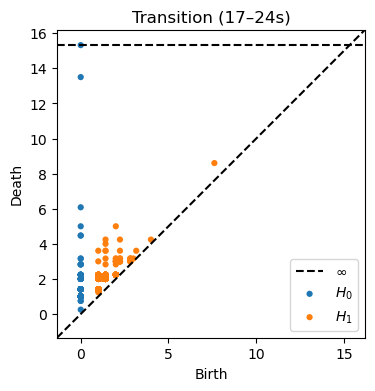

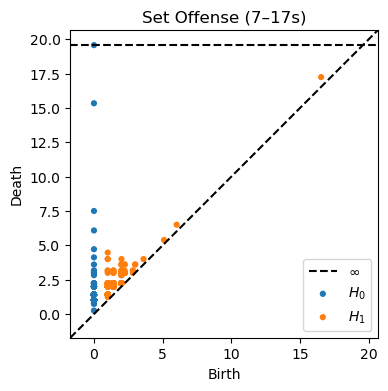

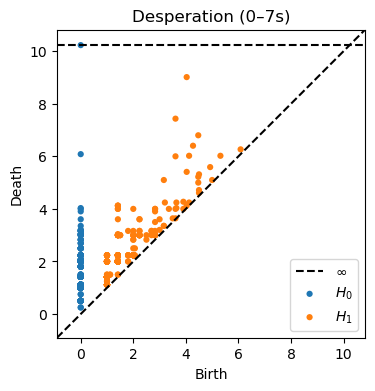

In [42]:
from persim import plot_diagrams
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plot_diagrams(dgms_trans, title="Transition (17–24s)")
plt.show()

plt.figure(figsize=(8,4))
plot_diagrams(dgms_set, title="Set Offense (7–17s)")
plt.show()

plt.figure(figsize=(8,4))
plot_diagrams(dgms_desp, title="Desperation (0–7s)")
plt.show()

In [43]:
import numpy as np

D = np.array([
    [0,            d_trans_set, d_trans_desp],
    [d_trans_set,  0,           d_set_desp ],
    [d_trans_desp, d_set_desp,  0]
])

D

array([[0.        , 1.        , 2.49137449],
       [1.        , 0.        , 2.49137449],
       [2.49137449, 2.49137449, 0.        ]])

In [44]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
coords = mds.fit_transform(D)

coords

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  Determines the random number generator used to initialize the centers.


array([[ 0.19198884,  0.93603735],
       [ 0.92269075,  0.24832927],
       [-1.11467959, -1.18436662]])

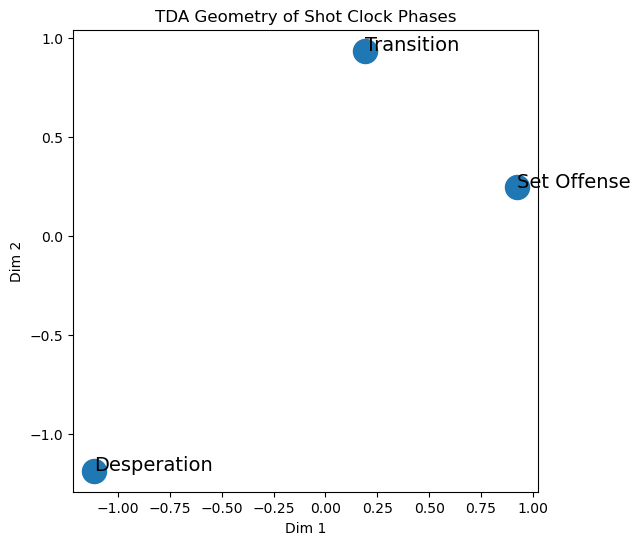

In [45]:
plt.figure(figsize=(6,6))
labels = ["Transition", "Set Offense", "Desperation"]

plt.scatter(coords[:,0], coords[:,1], s=300)

for i, txt in enumerate(labels):
    plt.annotate(txt, (coords[i,0], coords[i,1]), fontsize=14)

plt.title("TDA Geometry of Shot Clock Phases")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()